In [44]:
import numpy as numpy 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("../safetronics/human_vital_signs_dataset_2024.csv")

In [26]:
df.head()

,Patient ID,Heart Rate,Respiratory Rate,Timestamp,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP,Risk Category
0,1,60,12,2024-07-19 21:53:45.729841,36.861707,95.702046,124,86,37,Female,91.541618,1.679351,0.121033,38,32.459031,98.666667,High Risk
1,2,63,18,2024-07-19 21:52:45.729841,36.511633,96.689413,126,84,77,Male,50.704921,1.992546,0.117062,42,12.771246,98.000000,High Risk
2,3,63,15,2024-07-19 21:51:45.729841,37.052049,98.508265,131,78,68,Female,90.316760,1.770228,0.053200,53,28.821069,95.666667,Low Risk
3,4,99,16,2024-07-19 21:50:45.729841,36.654748,95.011801,118,72,41,Female,96.006188,1.833629,0.064475,46,28.554611,87.333333,High Risk
4,5,69,16,2024-07-19 21:49:45.729841,36.975098,98.623792,138,76,25,Female,56.020006,1.866419,0.118484,62,16.081438,96.666667,High Risk


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Patient ID                200020 non-null  int64  
 1   Heart Rate                200020 non-null  int64  
 2   Respiratory Rate          200020 non-null  int64  
 3   Timestamp                 200020 non-null  object 
 4   Body Temperature          200020 non-null  float64
 5   Oxygen Saturation         200020 non-null  float64
 6   Systolic Blood Pressure   200020 non-null  int64  
 7   Diastolic Blood Pressure  200020 non-null  int64  
 8   Age                       200020 non-null  int64  
 9   Gender                    200020 non-null  object 
 10  Weight (kg)               200020 non-null  float64
 11  Height (m)                200020 non-null  float64
 12  Derived_HRV               200020 non-null  float64
 13  Derived_Pulse_Pressure    200020 non-null  i

## Drop unused columns

In [28]:
df_1 = df.drop(['Respiratory Rate','Timestamp','Systolic Blood Pressure','Diastolic Blood Pressure','Derived_Pulse_Pressure','Derived_MAP'],axis=1)

In [29]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Patient ID         200020 non-null  int64  
 1   Heart Rate         200020 non-null  int64  
 2   Body Temperature   200020 non-null  float64
 3   Oxygen Saturation  200020 non-null  float64
 4   Age                200020 non-null  int64  
 5   Gender             200020 non-null  object 
 6   Weight (kg)        200020 non-null  float64
 7   Height (m)         200020 non-null  float64
 8   Derived_HRV        200020 non-null  float64
 9   Derived_BMI        200020 non-null  float64
 10  Risk Category      200020 non-null  object 
dtypes: float64(6), int64(3), object(2)
memory usage: 16.8+ MB


In [30]:
df_1.set_index('Patient ID', inplace=True)

In [31]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200020 entries, 1 to 200020
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Heart Rate         200020 non-null  int64  
 1   Body Temperature   200020 non-null  float64
 2   Oxygen Saturation  200020 non-null  float64
 3   Age                200020 non-null  int64  
 4   Gender             200020 non-null  object 
 5   Weight (kg)        200020 non-null  float64
 6   Height (m)         200020 non-null  float64
 7   Derived_HRV        200020 non-null  float64
 8   Derived_BMI        200020 non-null  float64
 9   Risk Category      200020 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 16.8+ MB


In [34]:
df_1.rename(columns={"Weight (kg)":"Weight","Derived_HRV":"HRV","Derived_BMI":"BMI"},inplace=True)

In [38]:
df_1.head()

,Heart Rate,Body Temperature,Oxygen Saturation,Age,Gender,Weight,Height (m),HRV,BMI,Risk Category
Patient ID,,,,,,,,,,
1,60,36.861707,95.702046,37,Female,91.541618,1.679351,0.121033,32.459031,High Risk
2,63,36.511633,96.689413,77,Male,50.704921,1.992546,0.117062,12.771246,High Risk
3,63,37.052049,98.508265,68,Female,90.316760,1.770228,0.053200,28.821069,Low Risk
4,99,36.654748,95.011801,41,Female,96.006188,1.833629,0.064475,28.554611,High Risk
5,69,36.975098,98.623792,25,Female,56.020006,1.866419,0.118484,16.081438,High Risk


In [39]:
# checking total category
df_1['Risk Category'].unique()

array(['High Risk', 'Low Risk'], dtype=object)

In [42]:
# mapping low risk and high risk to numeric valu
df_1['Risk Category'] = df_1['Risk Category'].map({"High Risk":1, "Low Risk":0})

In [43]:
df_1.head()

,Heart Rate,Body Temperature,Oxygen Saturation,Age,Gender,Weight,Height (m),HRV,BMI,Risk Category
Patient ID,,,,,,,,,,
1,60,36.861707,95.702046,37,Female,91.541618,1.679351,0.121033,32.459031,1
2,63,36.511633,96.689413,77,Male,50.704921,1.992546,0.117062,12.771246,1
3,63,37.052049,98.508265,68,Female,90.316760,1.770228,0.053200,28.821069,0
4,99,36.654748,95.011801,41,Female,96.006188,1.833629,0.064475,28.554611,1
5,69,36.975098,98.623792,25,Female,56.020006,1.866419,0.118484,16.081438,1


## Correlation Between Heart Rate and Risk Category

In [50]:
# calculating Pearson correlation for checking the correlation between
# Heart rate and Risk Category

# ensure for numeric value
df_1['Heart Rate'] = pd.to_numeric(df_1['Heart Rate'],errors='coerce')
# df_corr = df_1.dropna(subset=['Heart Rate', 'Risk Category']) // optional if NULL data 
df_corr = df_1[['Heart Rate','Risk Category']]

In [51]:
df_corr.head()

,Heart Rate,Risk Category
Patient ID,,
1,60,1
2,63,1
3,63,0
4,99,1
5,69,1


In [52]:
# pearson correlation
pearson = df_corr['Heart Rate'].corr(df_corr['Risk Category'])
print(f"Pearson: {pearson}")

Pearson: 0.36848667302916466


In [54]:
# point-biserial correlation
from scipy import stats
pb_r, pb_p = stats.pointbiserialr(df_corr['Heart Rate'],df_corr['Risk Category'])
print(f"point-biserial r={pb_r:.4f}, p={pb_p}")

point-biserial r=0.3685, p=0.0


In [55]:
# spearman correlation
spearman_p, spearman_b = stats.spearmanr(df_corr['Heart Rate'],df_corr['Risk Category'])
print(f"Spearman_p:{spearman_p}, spearman_b:{spearman_b}")

Spearman_p:0.36862211533431805, spearman_b:0.0


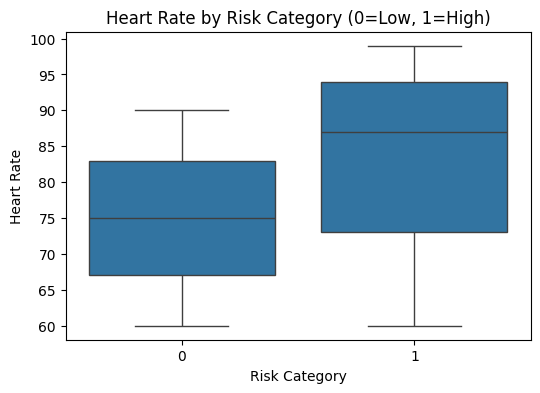

In [56]:
# Visualization between Heat Rate and Risk Category
plt.figure(figsize=(6,4))
sns.boxplot(x='Risk Category', y='Heart Rate', data=df_corr)
plt.title('Heart Rate by Risk Category (0=Low, 1=High)')
plt.xlabel("Risk Category")
plt.ylabel("Heart Rate")
plt.show()

## Correlation Between Body Temperature and Risk Category

In [57]:
# ensure for numeric value
df_1['Body Temperature'] = pd.to_numeric(df_1['Body Temperature'],errors='coerce')
# df_corr = df_1.dropna(subsets=['Body Temperature','Risk Category])   # option if NULL
df_Corr_2 = df_1[['Body Temperature','Risk Category']]
df_Corr_2.head()

,Body Temperature,Risk Category
Patient ID,,
1,36.861707,1
2,36.511633,1
3,37.052049,0
4,36.654748,1
5,36.975098,1


In [58]:
# pearson correlation
pearson_2 = df_Corr_2['Body Temperature'].corr(df_Corr_2['Risk Category'])
print(f"Pearson: {pearson_2}")

Pearson: 0.0011813385586117902


In [59]:
# point-biserial correlation
pb_r, pb_p = stats.pointbiserialr(df_Corr_2['Body Temperature'],df_Corr_2['Risk Category'])
print(f"pb_r:{pb_r}, pb_p:{pb_p}")

pb_r:0.0011813385586117954, pb_p:0.5972675637827833


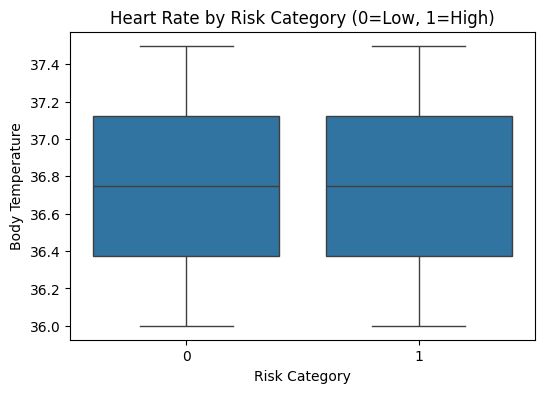

In [61]:
# Visualization between Heat Rate and Risk Category
plt.figure(figsize=(6,4))
sns.boxplot(x='Risk Category', y='Body Temperature', data=df_Corr_2)
plt.title('Heart Rate by Risk Category (0=Low, 1=High)')
plt.xlabel("Risk Category")
plt.ylabel("Body Temperature")
plt.show()

## Correlation between Oxygen Saturation and Risk Category

In [62]:
# ensore for numeric value
df_1['Oxygen Saturation'] = pd.to_numeric(df_1['Oxygen Saturation'],errors='coerce')
df_corr_3 = df_1[['Oxygen Saturation','Risk Category']]
df_corr_3.head()

,Oxygen Saturation,Risk Category
Patient ID,,
1,95.702046,1
2,96.689413,1
3,98.508265,0
4,95.011801,1
5,98.623792,1


In [63]:
# pearson correlation
pearson_3 = df_corr_3['Oxygen Saturation'].corr(df_corr_3['Risk Category'])
print(f"Pearson: {pearson_3}")

Pearson: -0.0006522071149840264


In [64]:
# point biserial
pb_r, pb_p = stats.pointbiserialr(df_corr_3['Oxygen Saturation'],df_corr_3['Risk Category'])
print(f"pb_r: {pb_r}, pb_b: {pb_p}")

pb_r: -0.0006522071149840282, pb_b: 0.770524664729982


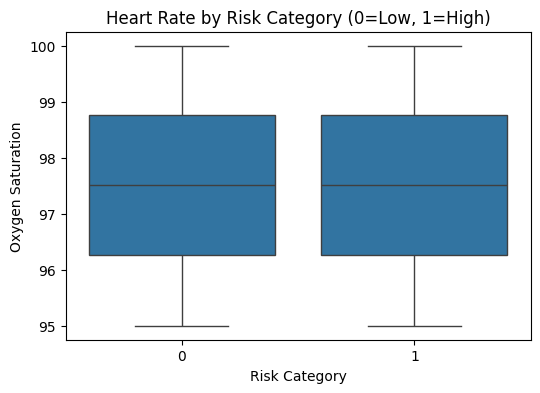

In [66]:
# Visualization between Heat Rate and Risk Category
plt.figure(figsize=(6,4))
sns.boxplot(x='Risk Category', y='Oxygen Saturation', data=df_corr_3)
plt.title('Heart Rate by Risk Category (0=Low, 1=High)')
plt.xlabel("Risk Category")
plt.ylabel("Oxygen Saturation")
plt.show()

In [ ]:
# Prepare data, train LinearRegression and LogisticRegression (binary target)
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# # ensure target numeric
# df_1['Risk Category'] = pd.to_numeric(df_1['Risk Category'], errors='coerce')

# # select numeric feature columns (drop target)
# num_cols = df_1.select_dtypes(include=['number']).columns.tolist()
# if 'Risk Category' in num_cols:
#     num_cols.remove('Risk Category')

# X = df_1[num_cols]
# y = df_1['Risk Category']

# # drop rows with missing values
# data = pd.concat([X, y], axis=1).dropna()
# X = data[num_cols]
# y = data['Risk Category']

# # train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # scale features
# scaler = StandardScaler()
# X_train_s = scaler.fit_transform(X_train)
# X_test_s = scaler.transform(X_test)

# # Linear regression (not ideal for binary target, used here for demonstration)
# lin = LinearRegression()
# lin.fit(X_train_s, y_train)
# y_pred_reg = lin.predict(X_test_s)

# print("LinearRegression evaluation (regression metrics):")
# print("R2:", r2_score(y_test, y_pred_reg))
# print("MSE:", mean_squared_error(y_test, y_pred_reg))

# # Logistic regression (appropriate for binary classification)
# log = LogisticRegression(max_iter=2000)
# log.fit(X_train_s, y_train)
# y_pred_clf = log.predict(X_test_s)

# print("\nLogisticRegression evaluation (classification metrics):")
# print("Accuracy:", accuracy_score(y_test, y_pred_clf))
# print("Precision:", precision_score(y_test, y_pred_clf, zero_division=0))
# print("Recall:", recall_score(y_test, y_pred_clf, zero_division=0))
# print("F1:", f1_score(y_test, y_pred_clf, zero_division=0))
# print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_clf))
# print("\nClassification report:\n", classification_report(y_test, y_pred_clf, zero_division=0))